# Integration with PHOEBE

In [1]:
from jax import config
import jax
config.update('jax_platform_name', 'cpu')
config.update('jax_enable_x64', True)

import phoebe
from spice.models.binary import PhoebeBinary
from spice.models.phoebe_utils import PhoebeConfig
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from spice.spectrum import simulate_observed_flux
from transformer_payne import Blackbody
from phoebe.parameters.dataset import _mesh_columns
%matplotlib inline

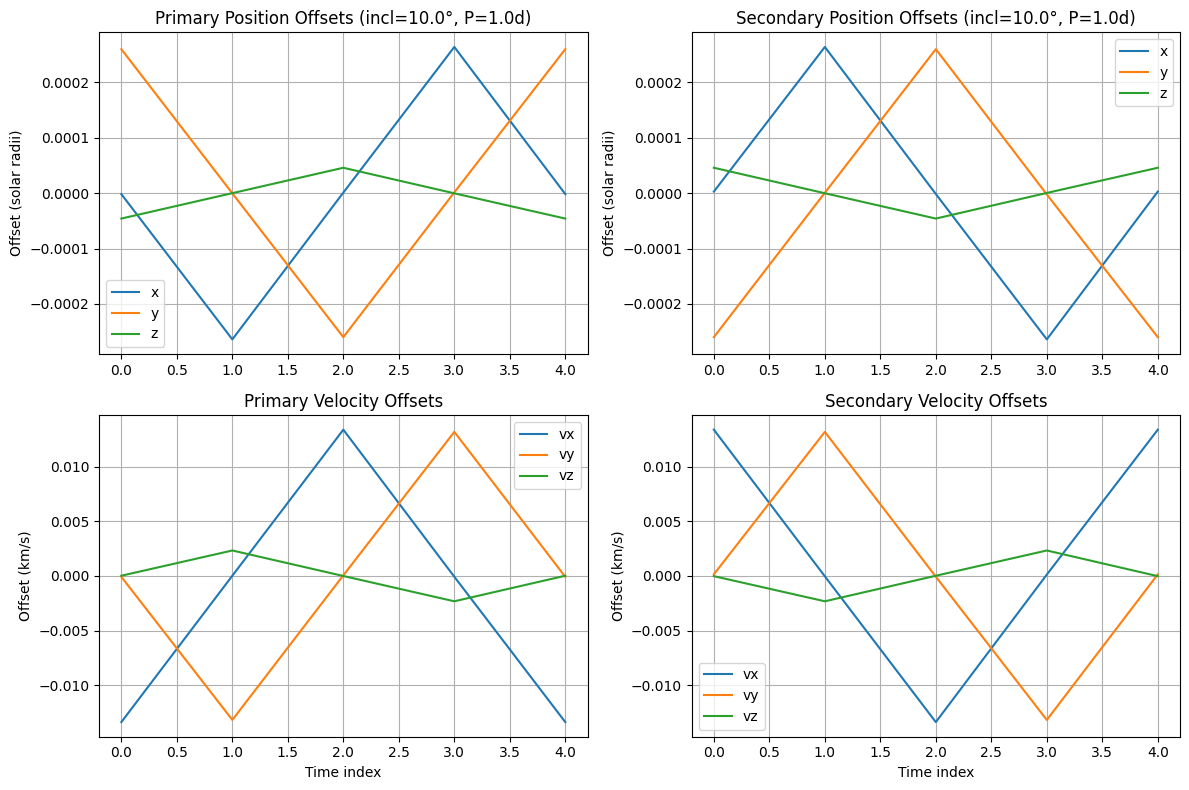

Comparison for inclination=10.0° and period=1.0 days:
Position offset RMS (primary): 0.00026409530101937387 solar radii
Position offset RMS (secondary): 0.00026410088907062525 solar radii
Velocity offset RMS (primary): 0.013386534446478353 km/s
Velocity offset RMS (secondary): 0.013386816628479448 km/s


In [28]:
import os
import numpy as np
from spice.models.binary import Binary, add_orbit, evaluate_orbit_at_times
from spice.models.mesh_model import IcosphereModel
from spice.models.mesh_view import get_mesh_view
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Function to load and analyze PHOEBE vs SPICE comparison data
def load_phoebe_comparison(filepath):
    """
    Load position and velocity offset data from a comparison file.
    
    Args:
        filepath (str): Path to the .npz file containing comparison data
        
    Returns:
        dict: Dictionary containing the loaded data
    """
    if not os.path.exists(filepath):
        print(f"File not found: {filepath}")
        return None
    
    data = np.load(filepath)
    return {key: data[key] for key in data.files}

# Load the comparison data
comparison_file = "/Users/mjablons/Documents/stellar-mesh-integration/tutorial/paper_results/phoebe_binaries_check/position_velocity_offsets_incl_10.0_period_1.0_q_1.0_ecc_0.0.npz"
comparison_data = load_phoebe_comparison(comparison_file)

if comparison_data:
    # Extract data
    # Extract position data for both stars
    phoebe_pos1 = comparison_data['phoebe_pos1']
    phoebe_pos2 = comparison_data['phoebe_pos2']
    spice_pos1 = comparison_data['spice_pos1']
    spice_pos2 = comparison_data['spice_pos2']
    
    # Extract velocity data for both stars
    phoebe_vels1 = comparison_data['phoebe_vels1']
    phoebe_vels2 = comparison_data['phoebe_vels2']
    spice_vels1 = comparison_data['spice_vels1']
    spice_vels2 = comparison_data['spice_vels2']
    
    # Calculate position and velocity offsets
    pos_offset1 = np.array(spice_pos1) - phoebe_pos1
    pos_offset2 = np.array(spice_pos2) - phoebe_pos2
    vel_offset1 = spice_vels1 - phoebe_vels1
    vel_offset2 = spice_vels2 - phoebe_vels2
    
    # Extract orbital parameters
    inclination = comparison_data['inclination']
    period = comparison_data['period']
    q = comparison_data['q']  # Mass ratio
    ecc = comparison_data['ecc']  # Eccentricity
    
    # Create a figure to visualize the offsets
    fig = plt.figure(figsize=(12, 8))
    gs = GridSpec(2, 2, figure=fig)
    
    # Position offsets for primary
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(pos_offset1[:, 0], label='x')
    ax1.plot(pos_offset1[:, 1], label='y')
    ax1.plot(pos_offset1[:, 2], label='z')
    ax1.set_title(f'Primary Position Offsets (incl={inclination}°, P={period}d)')
    ax1.set_ylabel('Offset (solar radii)')
    ax1.legend()
    ax1.grid(True)
    
    # Position offsets for secondary
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(pos_offset2[:, 0], label='x')
    ax2.plot(pos_offset2[:, 1], label='y')
    ax2.plot(pos_offset2[:, 2], label='z')
    ax2.set_title(f'Secondary Position Offsets (incl={inclination}°, P={period}d)')
    ax2.set_ylabel('Offset (solar radii)')
    ax2.legend()
    ax2.grid(True)
    
    # Velocity offsets for primary
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(vel_offset1[:, 0], label='vx')
    ax3.plot(vel_offset1[:, 1], label='vy')
    ax3.plot(vel_offset1[:, 2], label='vz')
    ax3.set_title('Primary Velocity Offsets')
    ax3.set_xlabel('Time index')
    ax3.set_ylabel('Offset (km/s)')
    ax3.legend()
    ax3.grid(True)
    
    # Velocity offsets for secondary
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.plot(vel_offset2[:, 0], label='vx')
    ax4.plot(vel_offset2[:, 1], label='vy')
    ax4.plot(vel_offset2[:, 2], label='vz')
    ax4.set_title('Secondary Velocity Offsets')
    ax4.set_xlabel('Time index')
    ax4.set_ylabel('Offset (km/s)')
    ax4.legend()
    ax4.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"Comparison for inclination={inclination}° and period={period} days:")
    print(f"Position offset RMS (primary): {np.sqrt(np.mean(np.sum(pos_offset1**2, axis=1)))} solar radii")
    print(f"Position offset RMS (secondary): {np.sqrt(np.mean(np.sum(pos_offset2**2, axis=1)))} solar radii")
    print(f"Velocity offset RMS (primary): {np.sqrt(np.mean(np.sum(vel_offset1**2, axis=1)))} km/s")
    print(f"Velocity offset RMS (secondary): {np.sqrt(np.mean(np.sum(vel_offset2**2, axis=1)))} km/s")
else:
    print(f"Could not load comparison data from {comparison_file}")


## PHOEBE Configuration and Binary System Setup

In this section, we set up a binary system using PHOEBE and prepare it for integration with SPICE.

We configure the binary system with default parameters, add datasets for mesh, orbit, and light curve.

To make the lightcurve comparision as close as possible, we are going to use a simple blackbody spectrum model and disable limb darkening manually.

1. Create a default binary system
2. Define time points for computation
3. Add mesh, orbit, and light curve datasets
4. Configure limb darkening and atmosphere models
5. Run initial computation


In [3]:
b = phoebe.default_binary()

# Time points are in days
times = np.linspace(0, 10, 5)

# Use all columns for the mesh dataset
COLUMNS = _mesh_columns
b.add_dataset('mesh', times=times, columns=COLUMNS, dataset='mesh01')
b.add_dataset('orb', compute_times=times, dataset='orb01')
b.set_value('period@binary@component', 10.0)
b.set_value('ecc@binary@component', 0.)
b.set_value('q@binary@component', 1.0)
b.flip_constraint('mass@primary', solve_for='sma')
b.set_value('mass@primary@component', 1.0)

b.add_dataset('lc', compute_times=times, passband='Johnson:V', dataset='lc01')
b.set_value_all('incl@binary', 45.0)

# Disable irradiation and finite light travel time effects
b.run_compute(irrad_method='none', coordinates='uvw', ltte=False)

100%|██████████| 5/5 [00:00<00:00, 41.11it/s]


<ParameterSet: 329 parameters | kinds: lc, mesh, orb>

In [4]:
b.get_parameter('mass@primary@component').value, b.get_parameter('mass@secondary@component').value, b.get_parameter('ecc@binary@component')

(1.0,
 0.9999999999999994,
 <Parameter: ecc=0.0 | keys: description, value, quantity, default_unit, limits, visible_if, copy_for, readonly, advanced, latexfmt>)

In [5]:
b.get_parameter('period@binary@component').value

10.0

In [6]:
u.day.to(u.year)

0.0027378507871321013

In [7]:
from spice.models.binary import Binary, add_orbit, evaluate_orbit_at_times
from spice.models.mesh_model import IcosphereModel
from spice.models.mesh_view import get_mesh_view
import matplotlib.pyplot as plt
import numpy as np
from spice.spectrum import simulate_observed_flux
from transformer_payne import Blackbody
import jax.numpy as jnp
%matplotlib inline


def default_icosphere(mass=1.):
    return get_mesh_view(IcosphereModel.construct(100, 1., mass, [5700, 0.], ['teff', 'abun']), jnp.array([0., 1., 0.]))

times_yr = times * 0.0027378507871321013

body1 = default_icosphere(b.get_parameter('mass@primary@component').value)
body2 = default_icosphere(b.get_parameter('mass@secondary@component').value)
binary = Binary.from_bodies(body1, body2)

binary = add_orbit(binary, P = b.get_parameter('period@binary@component').value*0.0027378507871321013, ecc = b.get_parameter('ecc@binary@component').value, T = 0.,
                   i = jnp.deg2rad(b.get_parameter('incl@binary@component').value), omega = b.get_parameter('per0@binary@component').value*0.017453292519943295,
                   Omega = b.get_parameter('long_an@binary@component').value*0.0027378507871321013,
                   mean_anomaly = b.get_parameter('mean_anom@binary@component').value*0.017453292519943295,
                   reference_time = 10*b.get_parameter('t0_ref@binary@component').value*0.0027378507871321013,
                   vgamma = b.get_parameter('vgamma').value,
                   orbit_resolution_points = len(times_yr))

pb1, pb2 = evaluate_orbit_at_times(binary, times_yr)

/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


In [8]:
from spice.models.orbit_utils import get_orbit_jax

orb = get_orbit_jax(times_yr, binary.body1.mass, binary.body2.mass, binary.P, binary.ecc, binary.T, binary.i, binary.omega, binary.Omega, binary.mean_anomaly, binary.reference_time)

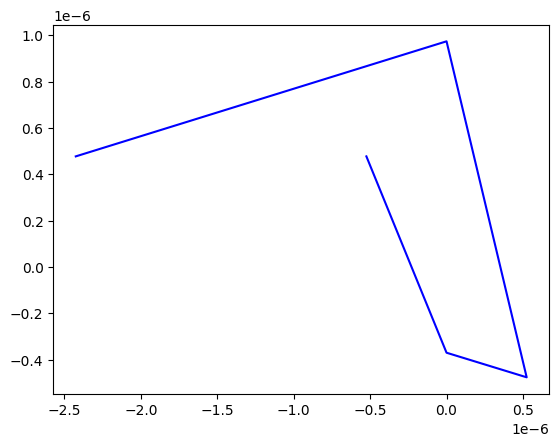

In [9]:
plt.plot(orb[0, :, 0], orb[0, :, 1], 'b-', label='SPICE primary')

In [10]:
b.filter(context='component').filter(kind='orbit').get_parameter('mean_anom')

<Parameter: mean_anom=89.99999559997653 deg | keys: description, value, quantity, default_unit, limits, visible_if, copy_for, readonly, advanced, latexfmt>

Let's use the simplest blackbody model.

We pass the parameter_values dict to PhoebeBinary.construct to initialize the binary system with specific parameters - since PHOEBE doesn't contain all of the parameters that can be used by the emulator, we need to add our own parameters to the mesh model. In the case of the blackbody model, this is not needed, as PHOEBE does contain temperature, but we'd need this line for e.g. abundances.


In [11]:
bb = Blackbody()

p1 = PhoebeConfig(b, 'mesh01', 'orb01')
pb = PhoebeBinary.construct(p1, bb.parameter_names, parameter_values={pn: sp for pn, sp in zip(bb.parameter_names, bb.solar_parameters)})

In [12]:
pb.P, pb.ecc, pb.T, pb.i, pb.omega, pb.Omega

(0.02737850787132101, 0.0, -0.006844626967830253, 0.7853981633974483, 0.0, 0.0)

In [13]:
b.get_parameter('period@binary@component'), b.get_parameter('per0@binary@component'), b.get_parameter('long_an@binary@component'), b.get_parameter('incl@binary@component'), b.get_parameter('t0_ref@binary@component'), b.get_parameter('ecc@binary@component'), b.get_parameter('sma@binary@component')

(<Parameter: period=10.0 d | keys: description, value, quantity, default_unit, limits, visible_if, copy_for, readonly, advanced, latexfmt>,
 <Parameter: per0=0.0 deg | keys: description, value, quantity, default_unit, limits, visible_if, copy_for, readonly, advanced, latexfmt>,
 <Parameter: long_an=0.0 deg | keys: description, value, quantity, default_unit, limits, visible_if, copy_for, readonly, advanced, latexfmt>,
 <Parameter: incl=45.0 deg | keys: description, value, quantity, default_unit, limits, visible_if, copy_for, readonly, advanced, latexfmt>,
 <Parameter: t0_ref=0.0 d | keys: description, value, quantity, default_unit, limits, visible_if, copy_for, readonly, advanced, latexfmt>,
 <Parameter: ecc=0.0 | keys: description, value, quantity, default_unit, limits, visible_if, copy_for, readonly, advanced, latexfmt>,
 <Parameter: sma=24.61016097887352 solRad | keys: description, value, quantity, default_unit, limits, visible_if, copy_for, readonly, advanced, latexfmt>)

In [14]:
b.get_parameter('sma@binary@component').description

'Semi-major axis of the orbit (defined at time t0@system)'

In [15]:
3351710536.915471/(u.solRad.to(u.m))

4.8177526763194924

In [16]:
b.get_parameter('vgamma')

<Parameter: vgamma=0.0 km / s | keys: description, value, quantity, default_unit, limits, visible_if, copy_for, readonly, advanced, latexfmt>

In [17]:
b.get_parameter('dpdt@binary@component'), b.get_parameter('dperdt@binary@component')

(<Parameter: dpdt=0.0 s / yr | keys: description, value, quantity, default_unit, limits, visible_if, copy_for, readonly, advanced, latexfmt>,
 <Parameter: dperdt=0.0 deg / yr | keys: description, value, quantity, default_unit, limits, visible_if, copy_for, readonly, advanced, latexfmt>)

In [18]:
pb.body1_velocities

array([[-6.22547636e+01,  2.69549448e-15, -2.69549448e-15],
       [-7.62400969e-15, -4.40207655e+01,  4.40207655e+01],
       [ 6.22547636e+01, -7.07907900e-15,  7.07907900e-15],
       [ 1.52480194e-14,  4.40207655e+01, -4.40207655e+01],
       [-6.22547636e+01,  1.24700680e-14, -1.24700680e-14]])

In [19]:
[_pb1.orbital_velocity for _pb1 in pb1]

[Array([-6.22609219e+01,  3.38090459e-06, -3.38090459e-06], dtype=float64),
 Array([-4.78132107e-06, -4.40251201e+01,  4.40251201e+01], dtype=float64),
 Array([ 6.22609219e+01, -3.38090455e-06,  3.38090455e-06], dtype=float64),
 Array([ 4.78132113e-06,  4.40251201e+01, -4.40251201e+01], dtype=float64),
 Array([-6.22609219e+01,  3.38090459e-06, -3.38090459e-06], dtype=float64)]

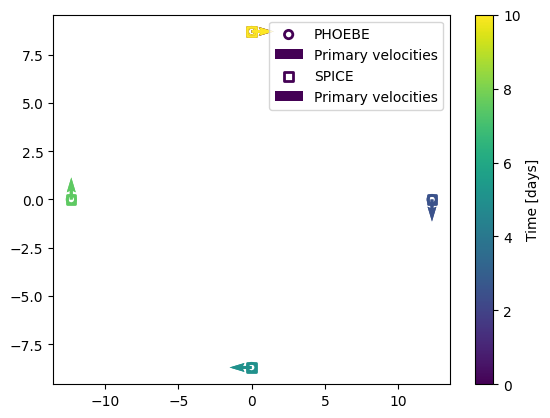

In [20]:
import astropy.units as u

R_SUN = u.R_sun.to(u.cm)

# Create a colormap based on time
colors = plt.cm.viridis(np.linspace(0, 1, len(times)))
colors2 = plt.cm.magma(np.linspace(0, 1, len(times)))

# Create figure and axis
fig, ax = plt.subplots()

j = 2
p_body_centers = pb.body2_centers
p_body_velocities = pb.body2_velocities
s_body = pb2

# Plot PHOEBE data with time-based borders
for i in range(len(p_body_centers)):
    ax.scatter(p_body_centers[i, 0], p_body_centers[i, j], 
                edgecolor=colors[i], facecolor='none', linewidth=2, label='PHOEBE' if i == 0 else None)
    ax.quiver(p_body_centers[i, 0], p_body_centers[i, j], 
               p_body_velocities[i, 0], p_body_velocities[i, j],
               color=colors[i], label='Primary velocities' if i == 0 else None)
    
# for i in range(len(pb.body1_centers)):
#     ax.scatter(pb.body2_centers[i, 0], pb.body2_centers[i, 1],
#                 edgecolor=colors2[i], facecolor='none', linewidth=2)
#     ax.quiver(pb.body2_centers[i, 0], pb.body2_centers[i, 1], 
#                pb.body1_velocities[i, 0], pb.body1_velocities[i, 1],
#                color=colors2[i], label='Primary velocities' if i == 0 else None)

# Plot SPICE data with time-based borders
for i, _pb1 in enumerate(s_body):
    ax.scatter(_pb1.center[0], _pb1.center[j], 
                edgecolor=colors[i], facecolor='none', linewidth=2, marker='s', label='SPICE' if i == 0 else None)
    ax.quiver(_pb1.center[0], _pb1.center[j], 
               _pb1.orbital_velocity[0], _pb1.orbital_velocity[j],
               color=colors[i], label='Primary velocities' if i == 0 else None)


# Add colorbar to show time progression
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=times.min(), vmax=times.max()))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Time [days]')

plt.legend()

Maximum position offsets (Primary): [0.00121724 0.00086072 0.00086072]
Maximum position offsets (Secondary): [0.00121724 0.00086072 0.00086072]
Maximum velocity offsets (Primary): [0.00615835 0.00435461 0.00435461]
Maximum velocity offsets (Secondary): [0.00615835 0.00435461 0.00435461]


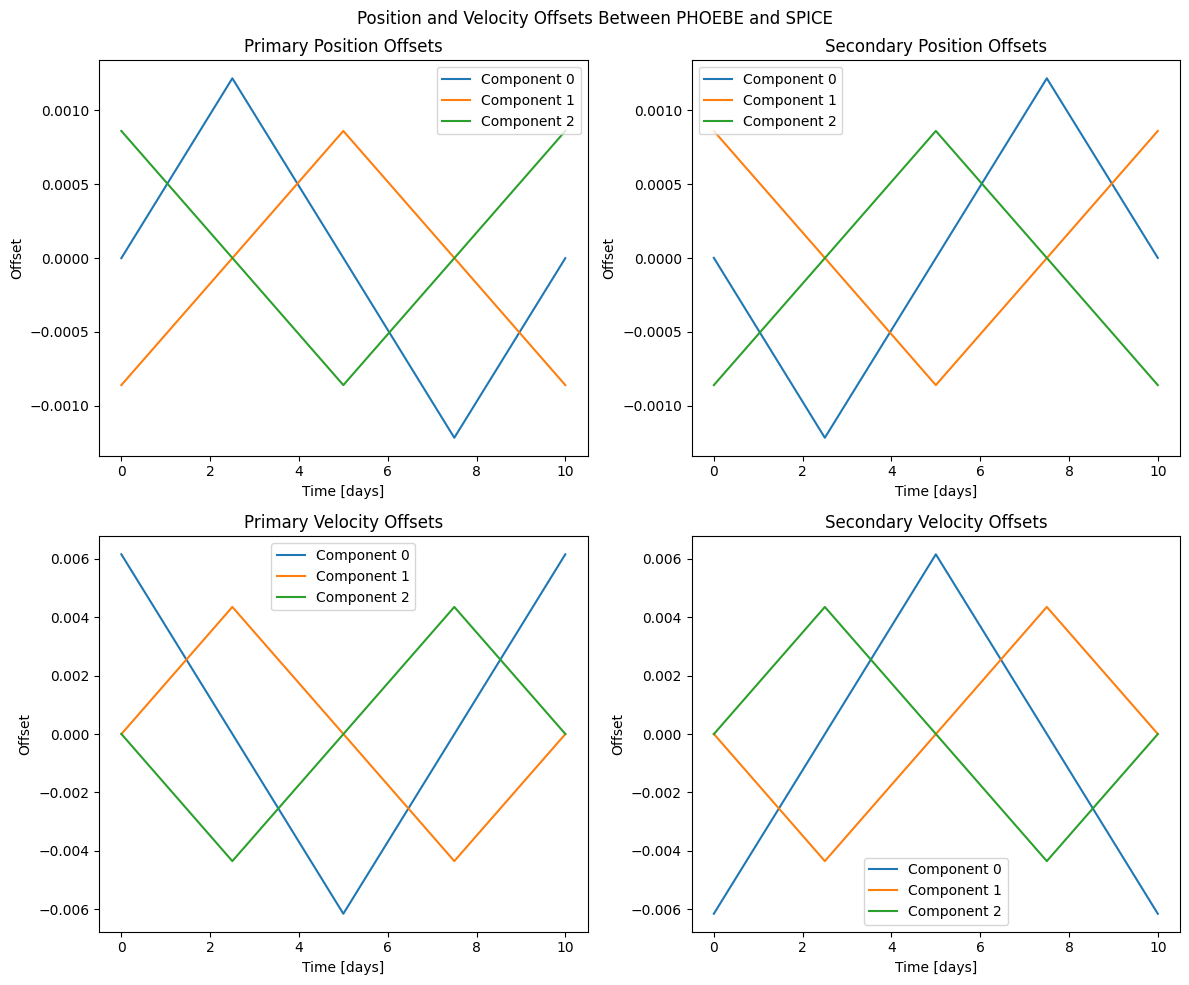

In [21]:
# Calculate position and velocity offsets
pos_offset1 = np.array(pb.body1_centers) - np.array([_pb1.center for _pb1 in pb1])
pos_offset2 = np.array(pb.body2_centers) - np.array([_pb2.center for _pb2 in pb2])
vel_offset1 = np.array(pb.body1_velocities) - np.array([_pb1.orbital_velocity for _pb1 in pb1])
vel_offset2 = np.array(pb.body2_velocities) - np.array([_pb2.orbital_velocity for _pb2 in pb2])

# Calculate maximum absolute offsets for each component
max_pos_offset1 = np.max(np.abs(pos_offset1), axis=0)
max_pos_offset2 = np.max(np.abs(pos_offset2), axis=0)
max_vel_offset1 = np.max(np.abs(vel_offset1), axis=0)
max_vel_offset2 = np.max(np.abs(vel_offset2), axis=0)

# Print the maximum offsets
print("Maximum position offsets (Primary):", max_pos_offset1)
print("Maximum position offsets (Secondary):", max_pos_offset2)
print("Maximum velocity offsets (Primary):", max_vel_offset1)
print("Maximum velocity offsets (Secondary):", max_vel_offset2)

# Create a figure to visualize the offsets over time
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Position and Velocity Offsets Between PHOEBE and SPICE')

# Plot position offsets
for i in range(3):  # x, y, z components
    axs[0, 0].plot(times, pos_offset1[:, i], label=f'Component {i}')
axs[0, 0].set_title('Primary Position Offsets')
axs[0, 0].set_xlabel('Time [days]')
axs[0, 0].set_ylabel('Offset')
axs[0, 0].legend()

for i in range(3):
    axs[0, 1].plot(times, pos_offset2[:, i], label=f'Component {i}')
axs[0, 1].set_title('Secondary Position Offsets')
axs[0, 1].set_xlabel('Time [days]')
axs[0, 1].set_ylabel('Offset')
axs[0, 1].legend()

# Plot velocity offsets
for i in range(3):
    axs[1, 0].plot(times, vel_offset1[:, i], label=f'Component {i}')
axs[1, 0].set_title('Primary Velocity Offsets')
axs[1, 0].set_xlabel('Time [days]')
axs[1, 0].set_ylabel('Offset')
axs[1, 0].legend()

for i in range(3):
    axs[1, 1].plot(times, vel_offset2[:, i], label=f'Component {i}')
axs[1, 1].set_title('Secondary Velocity Offsets')
axs[1, 1].set_xlabel('Time [days]')
axs[1, 1].set_ylabel('Offset')
axs[1, 1].legend()

plt.tight_layout()
plt.show()


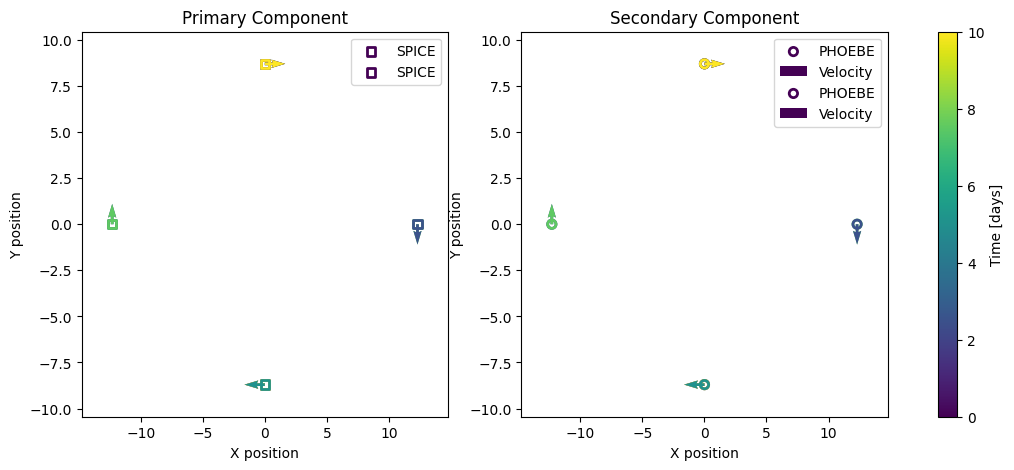

In [22]:
import astropy.units as u
import matplotlib.pyplot as plt

R_SUN = u.R_sun.to(u.cm)

# Create a colormap based on time
colors = plt.cm.viridis(np.linspace(0, 1, len(times)))
colors2 = plt.cm.magma(np.linspace(0, 1, len(times)))

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

j = 2  # Using y-coordinate

# Plot component 1 (Primary)
# PHOEBE data

# SPICE data
for i, _pb1 in enumerate(pb1):
    ax1.scatter(_pb1.center[0], _pb1.center[j], 
                edgecolor=colors[i], facecolor='none', linewidth=2, marker='s', label='SPICE' if i == 0 else None)
    ax1.quiver(_pb1.center[0], _pb1.center[j], 
               _pb1.orbital_velocity[0], _pb1.orbital_velocity[j],
               color=colors[i])
    
# SPICE data
for i, _pb2 in enumerate(pb2):
    ax1.scatter(_pb2.center[0], _pb2.center[j], 
                edgecolor=colors[i], facecolor='none', linewidth=2, marker='s', label='SPICE' if i == 0 else None)
    ax1.quiver(_pb2.center[0], _pb2.center[j], 
               _pb2.orbital_velocity[0], _pb2.orbital_velocity[j],
               color=colors[i])


ax1.set_title('Primary Component')
ax1.legend()

# Plot component 2 (Secondary)
# PHOEBE data
for i in range(len(pb.body1_centers)):
    ax2.scatter(pb.body1_centers[i, 0], pb.body1_centers[i, j], 
                edgecolor=colors[i], facecolor='none', linewidth=2, label='PHOEBE' if i == 0 else None)
    ax2.quiver(pb.body1_centers[i, 0], pb.body1_centers[i, j], 
               pb.body1_velocities[i, 0], pb.body1_velocities[i, j],
               color=colors[i], label='Velocity' if i == 0 else None)

for i in range(len(pb.body2_centers)):
    ax2.scatter(pb.body2_centers[i, 0], pb.body2_centers[i, j], 
                edgecolor=colors[i], facecolor='none', linewidth=2, label='PHOEBE' if i == 0 else None)
    ax2.quiver(pb.body2_centers[i, 0], pb.body2_centers[i, j], 
               pb.body2_velocities[i, 0], pb.body2_velocities[i, j],
               color=colors[i], label='Velocity' if i == 0 else None)

ax2.set_title('Secondary Component')
ax2.legend()

# Make sure both plots have the same axis range
all_x = np.concatenate([pb.body1_centers[:, 0], pb.body2_centers[:, 0], 
                        np.array([p.center[0] for p in pb1]), 
                        np.array([p.center[0] for p in pb2])])
all_y = np.concatenate([pb.body1_centers[:, j], pb.body2_centers[:, j], 
                        np.array([p.center[j] for p in pb1]), 
                        np.array([p.center[j] for p in pb2])])

x_min, x_max = np.min(all_x), np.max(all_x)
y_min, y_max = np.min(all_y), np.max(all_y)

# Add some padding
x_range = x_max - x_min
y_range = y_max - y_min
x_min -= 0.1 * x_range
x_max += 0.1 * x_range
y_min -= 0.1 * y_range
y_max += 0.1 * y_range

for ax in [ax1, ax2]:
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')

# Add colorbar to show time progression
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=times.min(), vmax=times.max()))
sm.set_array([])
cbar = fig.colorbar(sm, ax=[ax1, ax2])
cbar.set_label('Time [days]')

In [23]:
pbs_test = [_pb1 for i, _pb1 in enumerate(pb1)]
len(pbs_test)

5

In [25]:
pb1[0].orbital_velocity, pb.body1_velocities[0]

(Array([-6.22609219e+01,  3.38090459e-06, -3.38090459e-06], dtype=float64),
 array([-6.22547636e+01,  2.69549448e-15, -2.69549448e-15]))

In [26]:
spice_vels1 = np.array([_pb1.orbital_velocity for _pb1 in pb1])
spice_vels2 = np.array([_pb2.orbital_velocity for _pb2 in pb2])
phoebe_vels1 = pb.body1_velocities
phoebe_vels2 = pb.body2_velocities

In [27]:
phoebe_pos1 = pb.body1_centers
phoebe_pos2 = pb.body2_centers
spice_pos1 = np.stack([_pb1.center for _pb1 in pb1])
spice_pos2 = np.stack([_pb2.center for _pb2 in pb2])

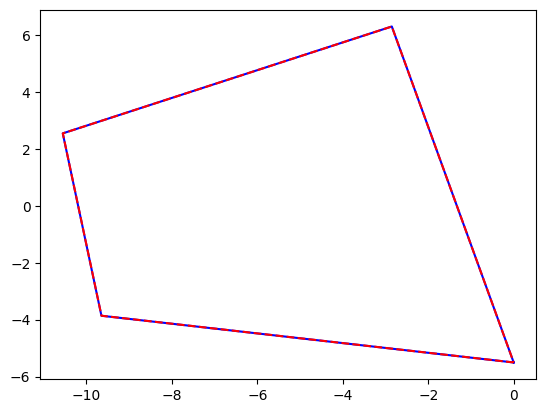

In [40]:
plt.plot(spice_pos1[:, 0], spice_pos1[:, 2], 'b-', label='SPICE primary')
plt.plot(phoebe_pos1[:, 0], phoebe_pos1[:, 2], 'r--', label='PHOEBE primary')

In [30]:
phoebe_vels1

array([[-4.94116386e+01,  1.77839733e-15, -2.44775393e-15],
       [-3.78515112e+01, -1.86687585e+01,  2.56953417e+01],
       [-8.58024100e+00, -2.86021975e+01,  3.93675475e+01],
       [ 2.47058193e+01, -2.51523503e+01,  3.46192402e+01],
       [ 4.64317522e+01, -9.93343893e+00,  1.36722058e+01],
       [ 4.64317522e+01,  9.93343893e+00, -1.36722058e+01],
       [ 2.47058193e+01,  2.51523503e+01, -3.46192402e+01],
       [-8.58024100e+00,  2.86021975e+01, -3.93675475e+01],
       [-3.78515112e+01,  1.86687585e+01, -2.56953417e+01],
       [-4.94116386e+01,  8.22733481e-15, -1.13239549e-14]])

Let's evaluate the orbit to create arrays of meshes with calculated parameters.

In [4]:
from spice.models.binary import evaluate_orbit_at_times

pb1, pb2 = evaluate_orbit_at_times(pb, times)

In [33]:
pb1[0].orbital_velocity

array([-1.34070739e+02,  5.02684756e-31, -8.20946507e-15])

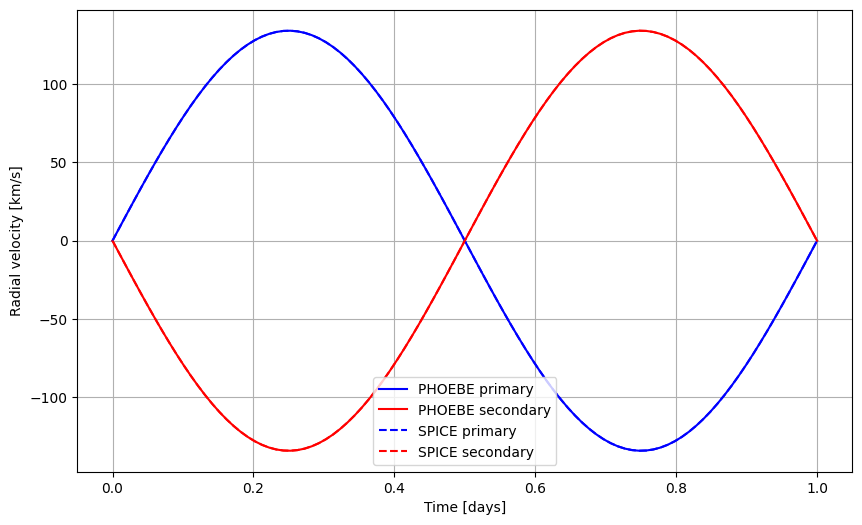

In [38]:
# Get velocities from PHOEBE
phoebe_vels1 = b.get_parameter('vws@primary@orb01@model').value
phoebe_vels2 = b.get_parameter('vws@secondary@orb01@model').value

# Get velocities from SPICE
# spice_vels1 = pb.body1_velocities[:, 2] #/ 1e5 # Convert from cm/s to km/s
# spice_vels2 = pb.body2_velocities[:, 2] #/ 1e5
spice_vels1 = [_pb1.orbital_velocity[2] for _pb1 in pb1]
spice_vels2 = [_pb2.orbital_velocity[2] for _pb2 in pb2]

plt.figure(figsize=(10,6))
plt.plot(times, phoebe_vels1, 'b-', label='PHOEBE primary')
plt.plot(times, phoebe_vels2, 'r-', label='PHOEBE secondary') 
plt.plot(times, spice_vels1, 'b--', label='SPICE primary')
plt.plot(times, spice_vels2, 'r--', label='SPICE secondary')
plt.xlabel('Time [days]')
plt.ylabel('Radial velocity [km/s]')
plt.legend()
plt.grid(True)


## Synthetic photometry

Let's calculate the observed flux (for the default value of $d=10$ pc) for both components. Note that we can **disable the Doppler shift**, which can be useful for comparisions with PHOEBE, as it doesn't include this effect because of computational concerns. (https://phoebe-project.org/docs/latest/tutorials/beaming_boosting)

In [3]:
ws = np.linspace(900, 40000, 1000)
s1s = [simulate_observed_flux(bb.intensity, _pb1, np.log10(ws), disable_doppler_shift=False) for _pb1 in pb1]
s2s = [simulate_observed_flux(bb.intensity, _pb2, np.log10(ws), disable_doppler_shift=False) for _pb2 in pb2]

s1s_no_d = [simulate_observed_flux(bb.intensity, _pb1, np.log10(ws), disable_doppler_shift=True) for _pb1 in pb1]
s2s_no_d = [simulate_observed_flux(bb.intensity, _pb2, np.log10(ws), disable_doppler_shift=True) for _pb2 in pb2]

NameError: name 'pb1' is not defined

Calculate the magnitude differences for the PHOEBE lightcurve.

In [6]:
diffs_phoebe = -2.5*np.log10(b.get_parameter('fluxes@lc01@model').value)

In [7]:
from spice.spectrum import AB_passband_luminosity
from spice.spectrum.filter import JohnsonV

johnsonV = JohnsonV()
lums = [AB_passband_luminosity(johnsonV, ws, s1[:, 0]+s2[:, 0]) for s1, s2 in zip(s1s, s2s)]
lums_no_d = [AB_passband_luminosity(johnsonV, ws, s1[:, 0]+s2[:, 0]) for s1, s2 in zip(s1s_no_d, s2s_no_d)]

Let's see the impact of Doppler shift on this system.

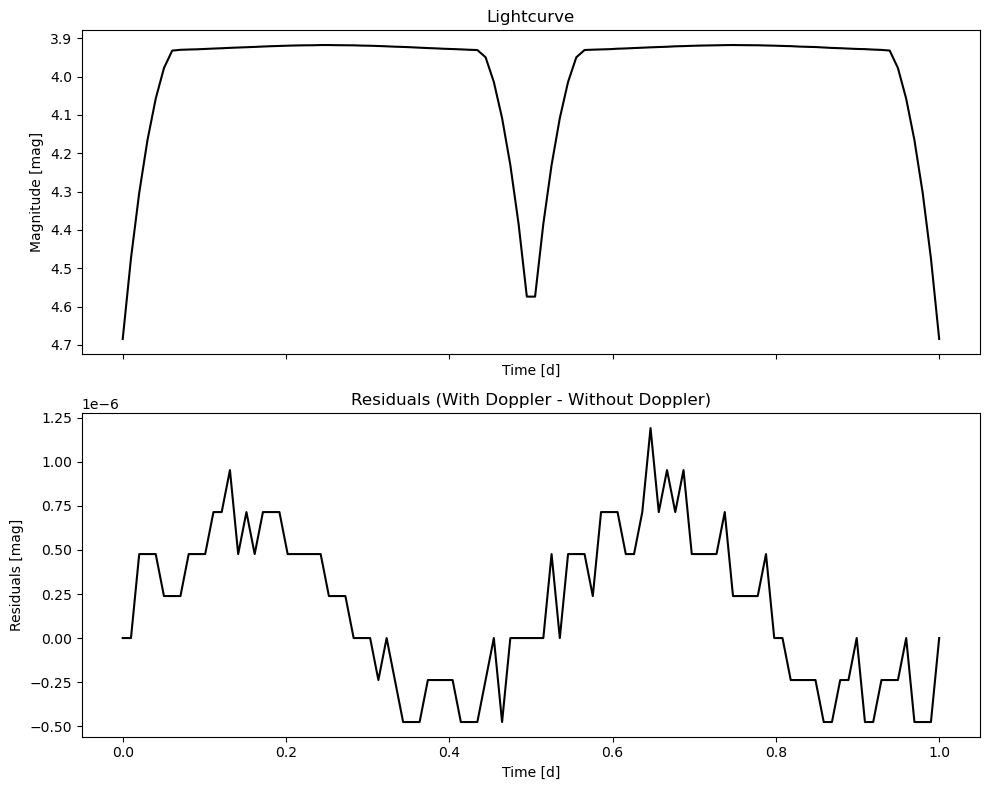

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot lightcurves
ax1.plot(times, lums, color='black')
ax1.invert_yaxis()
ax1.set_ylabel('Magnitude [mag]')
ax1.set_xlabel('Time [d]')
ax1.set_title('Lightcurve')

# Plot residuals
residuals = np.array(lums) - np.array(lums_no_d)
ax2.plot(times, residuals, color='black')
ax2.set_ylabel('Residuals [mag]')
ax2.set_xlabel('Time [d]')
ax2.set_title('Residuals (With Doppler - Without Doppler)')

plt.tight_layout()
plt.show()

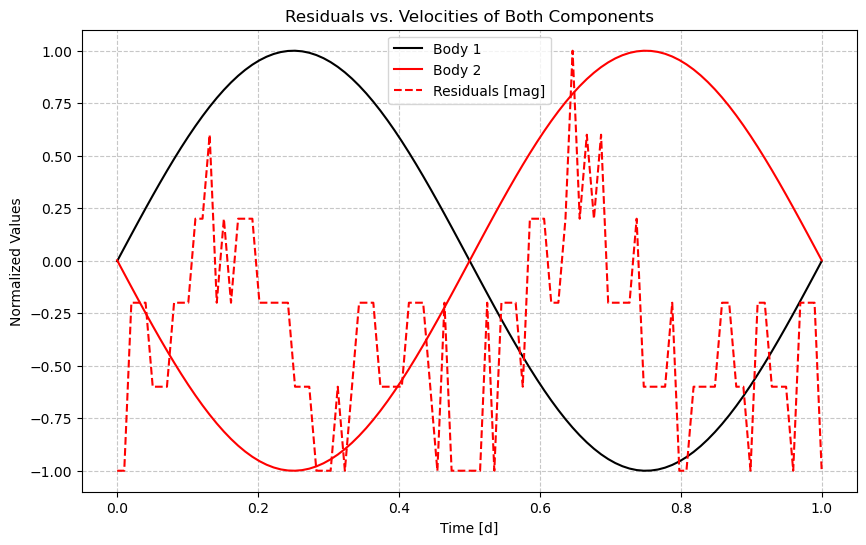

In [9]:
residuals = np.abs(np.array(lums) - np.array(lums_no_d))
vels1 = [np.mean(_pb1.los_velocities) for _pb1 in pb1]
vels2 = [np.mean(_pb2.los_velocities) for _pb2 in pb2]

plt.figure(figsize=(10, 6))
# Normalize velocities to -1, 1 range
vels1_norm = 2 * (np.array(vels1) - np.min(vels1)) / (np.max(vels1) - np.min(vels1)) - 1
vels2_norm = 2 * (np.array(vels2) - np.min(vels2)) / (np.max(vels2) - np.min(vels2)) - 1

# Plot normalized velocities for both components
plt.plot(times, vels1_norm, color='black', label='Body 1')
plt.plot(times, vels2_norm, color='red', label='Body 2')
# Normalize residuals to -1, 1 range
residuals_norm = 2 * (residuals - np.min(residuals)) / (np.max(residuals) - np.min(residuals)) - 1

# Plot normalized residuals
plt.plot(times, residuals_norm, label='Residuals [mag]', color='red', linestyle='--')

plt.xlabel('Time [d]')
plt.ylabel('Normalized Values')

plt.title('Residuals vs. Velocities of Both Components')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

We can see that in the case of this system, the Doppler shift shouldn't be that significant. Let's compare PHOEBE and SPICE lightcurves.

In [10]:
# We only care about the change in magnitudes, so we can subtract the first value

diffs_phoebe = diffs_phoebe-diffs_phoebe[0]
diffs_spice = np.array(lums_no_d)-lums_no_d[0]

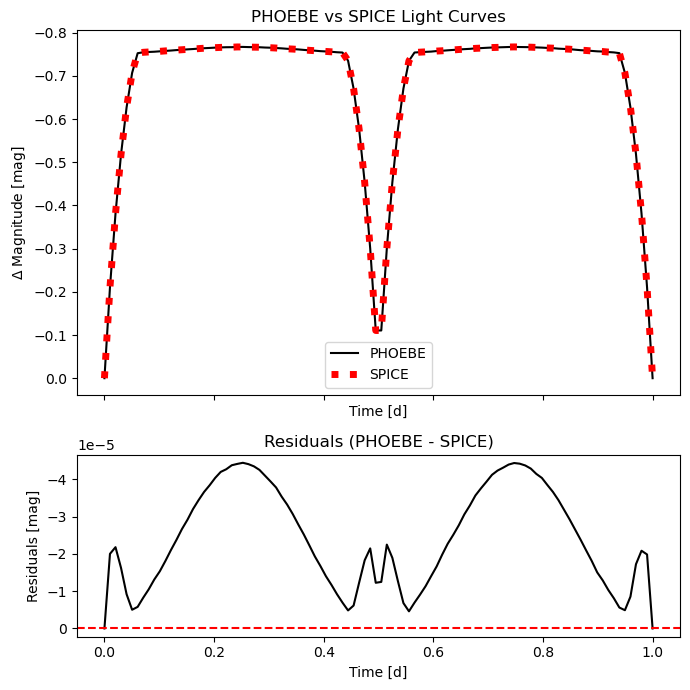

In [11]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Plot PHOEBE and SPICE data on the first subplot
ax1.plot(times, diffs_phoebe, color='black', label='PHOEBE')
ax1.plot(times, diffs_spice, color='red', linestyle='dotted', linewidth=5., label='SPICE')
ax1.invert_yaxis()
ax1.legend()
ax1.set_xlabel('Time [d]')
ax1.set_ylabel('$\Delta$ Magnitude [mag]')
ax1.set_title('PHOEBE vs SPICE Light Curves')

# Calculate and plot residuals on the second subplot
residuals = diffs_phoebe - diffs_spice
ax2.plot(times, residuals, color='black')
ax2.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
ax2.invert_yaxis()
ax2.set_xlabel('Time [d]')
ax2.set_ylabel('Residuals [mag]')
ax2.set_title('Residuals (PHOEBE - SPICE)')

plt.tight_layout()
plt.show()